# Stokes


On peut discrétiser l'équation biharmonique  $\nabla ^4 = \partial ^4_x + 2\partial^2_x\partial^2_y + \partial^4_y$ en utilisant la méthode des "central finite difference discretization" du second ordre, ce qui nous donne 



\begin{equation}
\nabla^4 u(i,j) = \frac{u(i+2, j) + u(i-2, j) + 6u(i, j) - 4 u(i+1, j) - 4u(i-1, j)}{dx^4} + \frac{u(i, j+2) + u(i, j-2) + 6u(i, j) - 4 u(i, j+1) - 4u(i, j-1)}{dy^4} + 2 \frac{u(i+1, j+1) + u (i+1, j-1) + u(i-1, j+1) + u(i-1, j-1) -2(u(i+1, j) + u(i-1, j) + u(i, j+1) + u(i, j-1)) +4u(i,j)}{dx^2 dy^2}
\end{equation}

Comme dx = dy 



\begin{equation}
\nabla^4 u(i,j) = \frac{20u(i,j) + u(i-2,j) + u(i,j-2) + u(i+2,j) + u(i,j+2) - 8[u(i-1,j) + u(i,j-1) + u(i+1,j) + u(i,j+1)}{dx^4} + \frac{2[u(i-1,j-1) + u(i-1,j+1) + u(i+1,j-1) + u(i+1,j+1)]}{dx^4}
\end{equation}

On implémente les condition de bord de Neumann en utilisant "forward or backward finite difference discretization" au second ordre. Nous devons faire attention que tout nos point entre dans le domaine car nous avont des point du style u(i-2,j), u(i+2,j) qui intervienne en fonction de la discrétisation forward ou backward. 

On a comme condition $\partial_x \psi$ = 0 et $\partial_y \psi$ = 0 ou 1 

Pour le coter bas et gauche nous utiliseron une "forward finite difference discretization" et pour le haut et droit une "backward finite difference discretization".

Backward finite difference discretization:

\begin{equation}
\partial_x u(i,j) = \frac{\frac{3}{2}u(i,j) - 2u(i-1,j) + \frac{1}{2}u(i-2,j)}{dx}
\end{equation}

Ce qui nous donne 

\begin{equation}
\psi(i,j) = \frac{2}{3}[2\psi(i-1,j) - \frac{1}{2}\psi(i-2,j)]
\end{equation}

Forward finite difference discretization:

\begin{equation}
\partial_x u(i,j) = \frac{-\frac{3}{2}u(i,j) + 2u(i+1,j) - \frac{1}{2}u(i+2,j)}{dx}
\end{equation}

Ce qui nous donne 

\begin{equation}
\psi(i,j) = \frac{2}{3}[2\psi(i+1,j) - \frac{1}{2}\psi(i+2,j)]
\end{equation}

On résoud ensuite l'équation biharmonique 

In [1]:
import numpy
import numba
from numba import jit
from matplotlib import pyplot
%matplotlib inline

In [2]:
# Parameters 
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)


u = 1.

l1_target = 1e-8

# Initialization for psi 
p = numpy.zeros((nx,nx))  # Dirichlet BCs are automatically enforced
# w = numpy.zeros((nx,nx))

In [3]:
@jit
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

In [4]:
def biharm(p, dx, u):
    
    ''' Calculate biharmonique with BC
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    dx: float
        Mesh spacing
    u : parameter for Neumann BC 
    
    Returns:
    -------
    biharm: 2D array of float
        biharmonic of p
    
    '''
    
    a = p.copy()
        
    # Enforce Neumann BC
    #Top
    a[-1,0:] = (2/3) * (dx*u + 2 * a[-2,0:] - (1/2) * a[-3,0:])
    #Bot
    a[0,0:] = (2/3) * (2 * a[1,0:] - (1/2) * a[2,0:])
    #Left
    a[0:,0] = (2/3) * (2 * a[0:,1] - (1/2) * a[0:,2])
    #Right 
    a[0:,-1] = (2/3) * (2 * a[0:,-1] - (1/2) * a[0:,-2])
        
    
    biharm = numpy.zeros(a.shape)
    biharm[2:-2,2:-2] = (20*a[2:-2,2:-2] + a[:-4,2:-2] + a[2:-2,:-4] + a[4:,2:-2] + a[2:-2,4:] - \
    8 * (a[1:-3,2:-2] + a[2:-2,1:-3] + a[3:-1,2:-2] + a[2:-2,3:-1]) + \
    2 * (a[1:-3,1:-3] + a[1:-3,3:-1] + a[3:-1,1:-3] + a[3:-1,3:-1]))/(dx**4)
    
    
    return biharm
    

In [5]:
def conjugate_gradient_Cours(p, dx, l2_target):
    '''Performs cg relaxation
    Assumes Dirichlet boundary conditions p=0
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing 
    
    l2_target: float
        exit criterion
        
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    ny, nx = p.shape
    r  = numpy.zeros((ny,nx)) # residual
    Ad  = numpy.zeros((ny,nx)) # to store result of matrix multiplication 
    
    l1_norm = 1
    iterations = 0
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    
    r = -biharm(p, dx, u)
    d = r.copy()
    rho = numpy.sum(r*r)
    Ad = biharm(d, dx, u)
    sigma = numpy.sum(d*Ad)
    
    # Iterations
    while l1_norm > l1_target:

        pk = p.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma

        p = pk + alpha*dk
        r = rk- alpha*Ad
        
        rhop1 = numpy.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        
        d = r + beta*dk
        Ad = biharm(d, dx, u)
        sigma = numpy.sum(d*Ad)
        
        # BCs are automatically enforced
        
        l1_norm = L1norm(pk,p)
        iterations += 1
        
    
    print('Number of CG iterations: {0:d}'.format(iterations))
    return p

In [6]:
#p = numpy.zeros((ny,nx))
p = conjugate_gradient_Cours(p, dx, l1_target)

Number of CG iterations: 63775


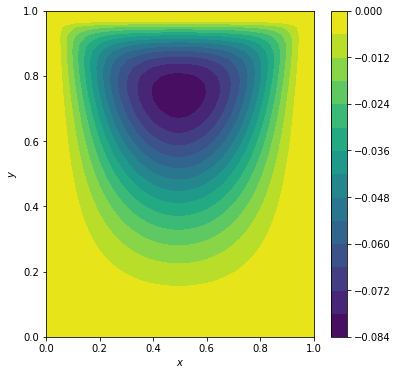

In [10]:
x=numpy.linspace(0, l, nx)
y=numpy.linspace(0, h, ny)
pyplot.figure(figsize=(6,6))
pyplot.contourf(x,y,p,15)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar()

Value of the stream function at location (x,y): (0.6,0.2), (0.6,0.4), (0.6,0.6), (0.6,0.8)

In [37]:
print("value at (0.6,0.2) =" , p[8,24])
print("value at (0.6,0.4) =", p[16,24])
print("value at (0.6,0.6) =", p[24,24])
print("value at (0.6,0.8) =", p[32,24])

value at (0.6,0.2) = -0.00871707547751
value at (0.6,0.4) = -0.0314493645534
value at (0.6,0.6) = -0.0630539370419
value at (0.6,0.8) = -0.0757084226159
